# Intro

OpenAI's CLIP (Contrastive Language-Image Pretraining) model is a machine learning model designed to understand and generate meaningful representations of images and text. It is trained on a large dataset of images and their associated textual descriptions, learning to associate images with their corresponding text.
The key innovation in CLIP is its use of contrastive learning, which involves training the model to recognize the correct pairing of an image and its description among a set of incorrect pairings. This approach enables the model to learn a wide range of visual concepts and their textual representations, making it capable of performing various tasks, such as image classification, object detection, and zero-shot learning.
CLIP's ability to understand both images and text allows it to be used in a variety of applications, including image search, content moderation, and generating image captions. Its versatility and performance have made it a popular choice for researchers and developers working on computer vision and natural language processing tasks.

In this notebook we are going to use a pretrained CLIP model for zero-shot object detection.

# Imports

In [19]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-9zc62o4g
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-9zc62o4g
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [20]:
import clip
import torch
import requests
import numpy as np
import torchvision
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
from torchvision.utils import draw_bounding_boxes

# Data

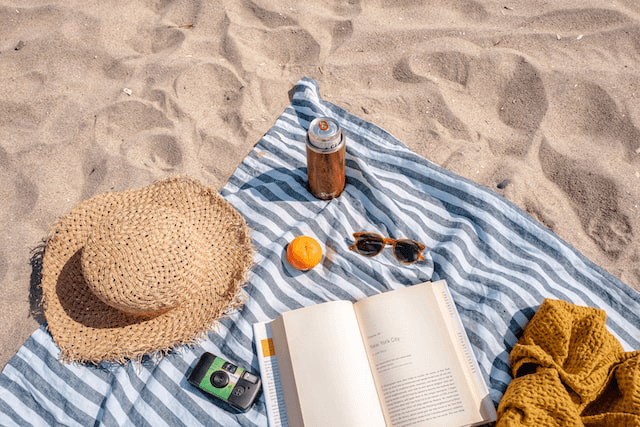

In [21]:
response = requests.get('https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/zero-sh-obj-detection_3.png')
img = Image.open(BytesIO(response.content)).convert("RGB")
img

# Extracting candidate regions

For this part use the RegionProposalNetwork in a pretrained faster rcnn to extract some candidate regions of different objects. Then visualize all the bounding boxes. You should get an image like this:

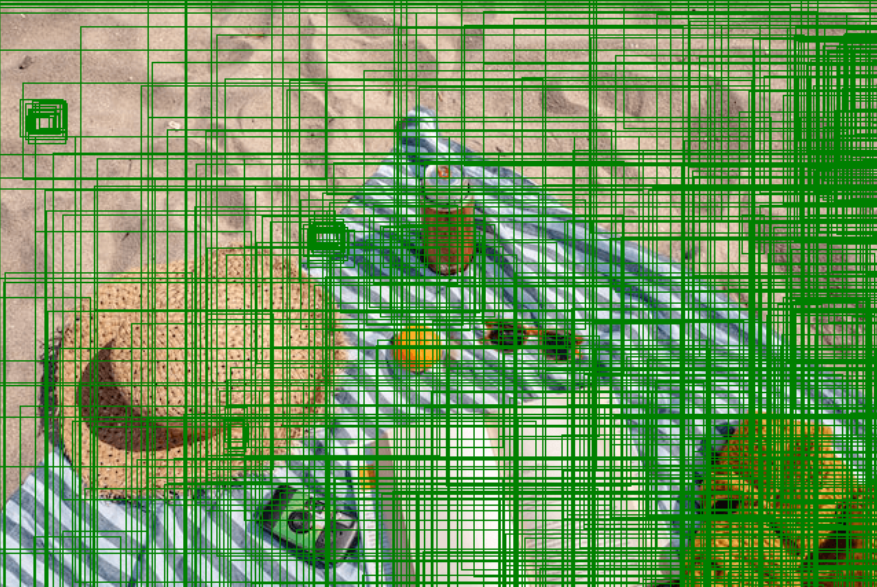

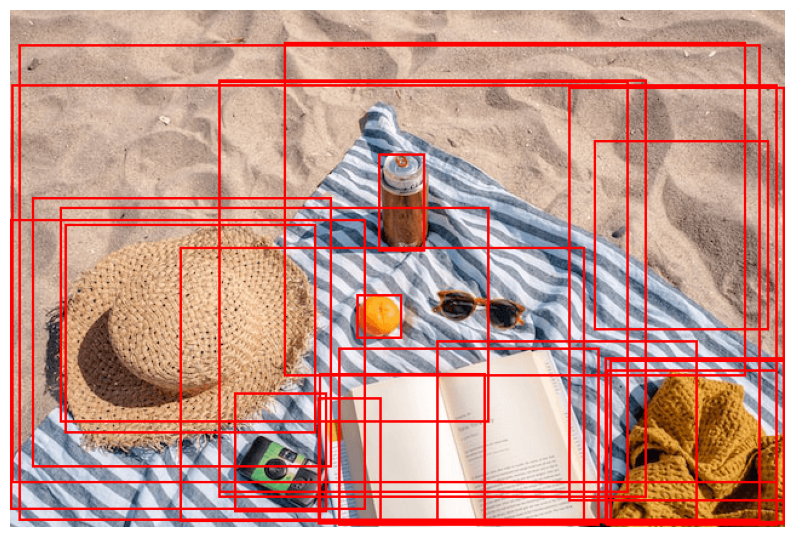

In [22]:
response = requests.get('https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/zero-sh-obj-detection_3.png')
img = Image.open(BytesIO(response.content)).convert("RGB")

faster_rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
faster_rcnn.eval() ; 

# =========================== BEGIN ===========================
transform = transforms.ToTensor()
img_tensor = transform(img).unsqueeze(0)
proposals = faster_rcnn(img_tensor)[0]

boxes = proposals['boxes']

# Convert the boxes to integer coordinates
boxes = boxes.int()

img_tensor_uint8 = (img_tensor.squeeze(0) * 255).byte()

# Draw the bounding boxes on the image
img_with_boxes = draw_bounding_boxes(img_tensor_uint8, boxes, colors="red", width=2)

# Convert the image with bounding boxes back to PIL format for visualization
img_with_boxes_pil = transforms.ToPILImage()(img_with_boxes)

# Display the image with bounding boxes
plt.figure(figsize=(10,10))
plt.imshow(img_with_boxes_pil)
plt.axis('off')
plt.show()
# =========================== END =============================

# Object Detection

Now extract the CLIP representation of candidate regions and query text. In order to get better results you need to use an ensemble of prompts for your query. For each query write multiple similar prompts like the given example. Average the embedding of all prompts to get a representation of your query and then compute the cosine similarity between the query and region candidates and return the most likely. Do this for all the queries specified below and save the results in the notebook.

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)


# Preprocess the original image and convert to tensor
img_pil = img.convert("RGB")
img_tensor_uint8 = (img_tensor.squeeze(0) * 255).byte()

# Extract and preprocess candidate regions
regions = []
for box in boxes:
    region = img_pil.crop(box.tolist())  # Crop the region
    region = preprocess(region).unsqueeze(0).to(device)  # Preprocess and add batch dimension
    regions.append(region)

# Stack all region tensors
region_tensors = torch.cat(regions)

# Get image embeddings for the candidate regions
with torch.no_grad():
    region_features = model.encode_image(region_tensors)

# Define the queries and their prompts
queries = {
    'hat': ['a hat', 'a photo of a hat', 'a picture of a brown hat'],
    'camera': ['a camera', 'a photo of a camera', 'a picture of a black camera'],
    'book': ['a book', 'a photo of a book', 'a picture of an open book'],
    'fruit': ['a fruit', 'a photo of a fruit', 'a picture of an orange fruit'],
    'sunglasses': ['sunglasses', 'a photo of sunglasses', 'a picture of black sunglasses'],
    'drink': ['a drink', 'a photo of a drink', 'a picture of a refreshing drink']
}

# Perform zero-shot classification for each query
results = {}
for query_name, query_prompts in queries.items():
    # Encode the text prompts and average their embeddings
    text_inputs = torch.cat([clip.tokenize(prompt).to(device) for prompt in query_prompts])
    with torch.no_grad():
        text_features = model.encode_text(text_inputs)
    text_features = text_features.mean(dim=0, keepdim=True)

    # Compute cosine similarity between text and region features
    similarities = F.cosine_similarity(text_features, region_features)

    # Get the index of the most similar region
    best_idx = similarities.argmax().item()
    best_box = boxes[best_idx]

    # Save the result
    results[query_name] = {
        'box': best_box,
        'similarity': similarities[best_idx].item()
    }

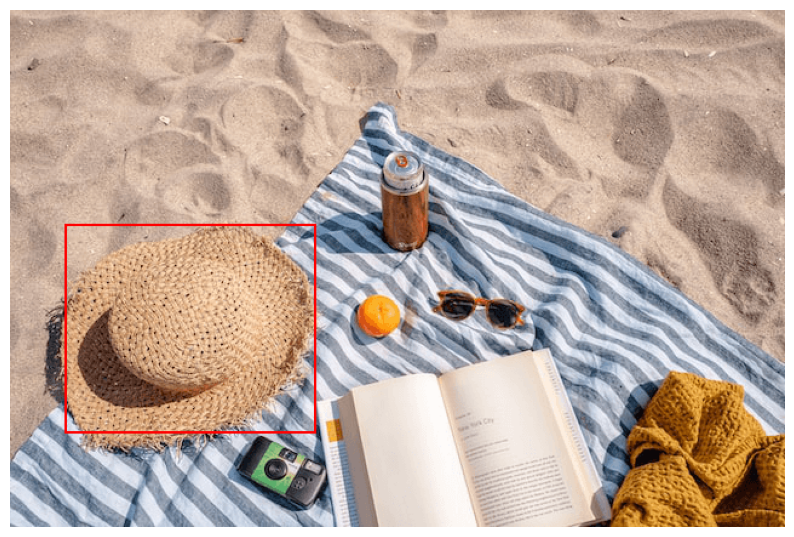

Query: hat
Most similar region: [45, 177, 252, 349]
Cosine similarity: 0.2866



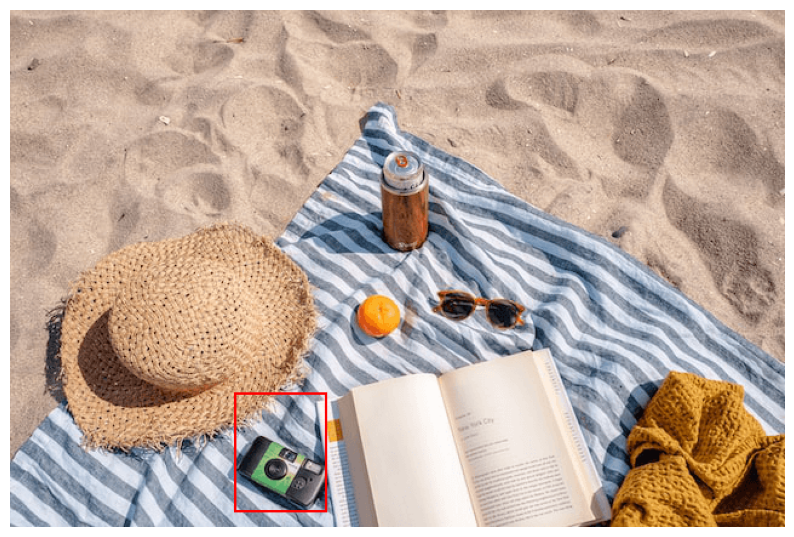

Query: camera
Most similar region: [185, 316, 261, 414]
Cosine similarity: 0.2565



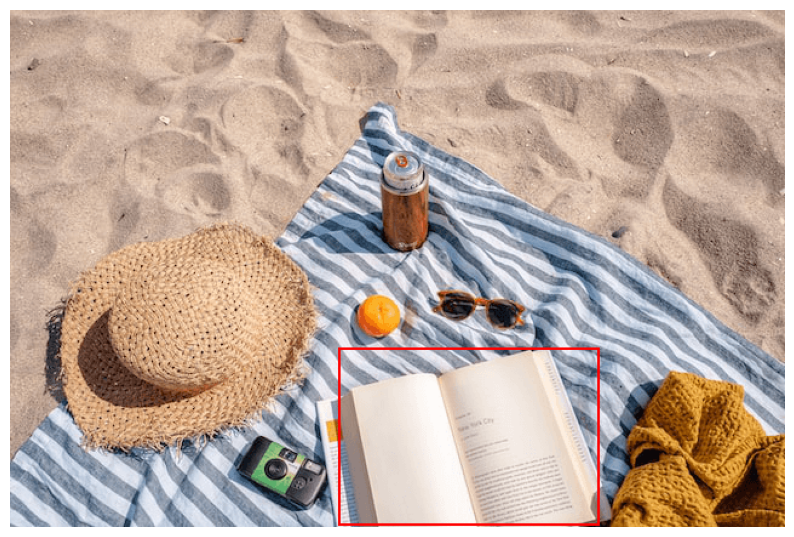

Query: book
Most similar region: [271, 279, 486, 425]
Cosine similarity: 0.2764



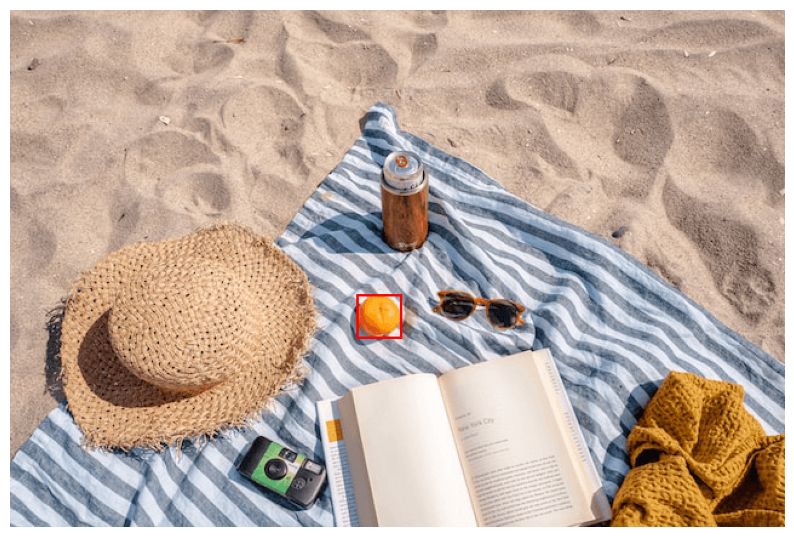

Query: fruit
Most similar region: [286, 235, 323, 271]
Cosine similarity: 0.2583



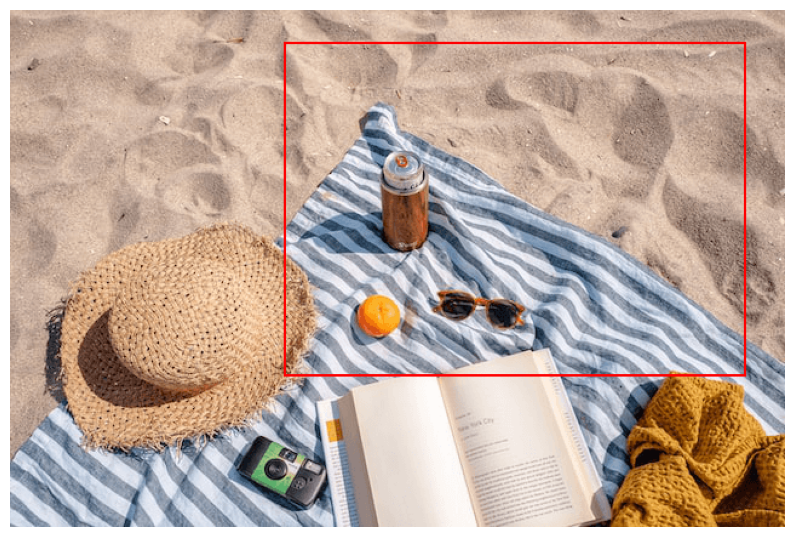

Query: sunglasses
Most similar region: [226, 27, 607, 302]
Cosine similarity: 0.2399



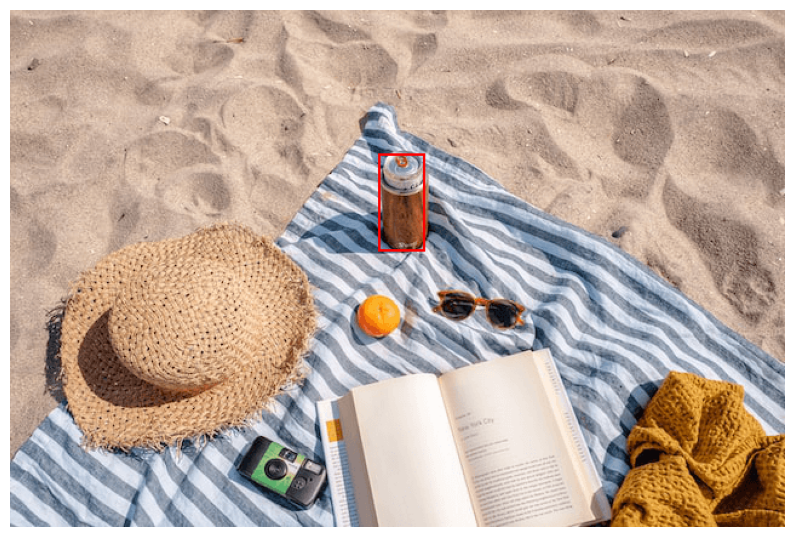

Query: drink
Most similar region: [304, 119, 342, 199]
Cosine similarity: 0.2522



In [24]:
# Visualize the results
for query_name, result in results.items():
    box = result['box'].unsqueeze(0)
    img_with_boxes = img_tensor_uint8.clone()
    img_with_boxes = draw_bounding_boxes(img_with_boxes, box, colors="red", width=2)

    # Convert the image with bounding boxes back to PIL format for visualization
    img_with_boxes_pil = transforms.ToPILImage()(img_with_boxes)

    # Display the image with bounding boxes
    plt.figure(figsize=(10,10))
    plt.imshow(img_with_boxes_pil)
    plt.axis('off')
    plt.show()

    # Print out the most similar region and its similarity score for each query
    print(f"Query: {query_name}")
    print(f"Most similar region: {result['box'].tolist()}")
    print(f"Cosine similarity: {result['similarity']:.4f}")
    print()